In [106]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, GRU
from keras.optimizers import Adam
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
# from numpy import argmax
# from pickle import load
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import load_model
# # from nltk.translate.bleu_score import corpus_bleu
import json
# import random
import csv

import keras.optimizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

#Wesam
# SEED = 10
ROOT_DIR = "/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/"
IMAGE_EMBEDDING_DIR = ROOT_DIR
IMAGE_EMBEDDING_VAL_DIR = ROOT_DIR

TEST_IMAGE_DIR = ROOT_DIR + "images/train/images/train/"
# IMAGE_EMBEDDING_DIR = '/content/drive/My Drive/Colab_Notebooks/DL_data/one_sample_cnn/'
# NUM_IMAGE_EMBEDDING_CHUNKS = 1
GLOVE_EMBEDDING_FILE_NAME = 'glove.6B.50d.txt'
# MAX_SEQUENCE_LENGTH = 92
# WORD_EMBEDDING_DIM = 300
CAPTION_FILE_NAME = ROOT_DIR+'image_to_caption.csv'
# filepath = '/content/drive/My Drive/Colab_Notebooks/DL_data/model-ep{epoch:03d}-loss{loss:.3f}.h5'

#Vinuta
SEED = 10
#IMAGE_EMBEDDING_DIR = '/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/'
NUM_IMAGE_EMBEDDING_CHUNKS = 1
#GLOVE_EMBEDDING_FILE_NAME = 'glove.6B.300d.txt'
MAX_SEQUENCE_LENGTH = 92
WORD_EMBEDDING_DIM = 50
#CAPTION_FILE_NAME = '/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/image_to_caption.csv'

In [107]:
# from google.colab import drive
# drive.mount('/content/drive')

#PreProcess Captions

In [108]:
def getCaptions(id_list):
    caption_dict = {}
    with open(CAPTION_FILE_NAME) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if row[1] in id_list:
                caption_dict[row[1]] = ['startseq ' + row[2] + ' endseq']
                #caption_dict[row[1]] = 'startseq ' + row[2] + ' endseq'
    return caption_dict

In [109]:
def vocab_fun(captions):
  index_to_word = {}
  word_to_index = {}
  all_words = {}
  for img_id, cap in captions.items():
      for c in cap:
          for word in c.split():
            all_words[word] = 1
  all_vocab=[w for w in all_words]
  index = 0
  for word in all_vocab:
      word_to_index[word] = index
      index_to_word[index] = word
      index += 1
  return (all_vocab, word_to_index, index_to_word)

#Preprocess images

In [110]:
def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res 

def getImageEmbedding(path):
    image_embedding = {}
    for i in range(NUM_IMAGE_EMBEDDING_CHUNKS):
        file_name = path + 'cnn_group'+str(i+1)+'.json'
        with open(file_name) as json_file:
#     with open('json_1000_images') as json_file:
            json_data = json.load(json_file)
            json_data = json.loads(json_data)
            image_embedding = Merge(image_embedding, json_data) 
            #image_embedding = json_data 
    print(len(image_embedding))
    return image_embedding

In [111]:
# xx = getImageEmbedding()
# yy = {}
# for x in list(reversed(list(xx)))[0:1000]:
#     yy[x] = xx[x]
    
# j = json.dumps(yy)
# with open("json_1000_images", 'w') as outfile:
#     json.dump(j, outfile)

#for fit_generator:

In [112]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch): #descriptions are captions
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split() if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photos[key])
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

#Use Prev to get captions and images and pre_process them

In [113]:
#for training
image_embd =  getImageEmbedding(IMAGE_EMBEDDING_DIR)
print(len(image_embd))
image_embd_train=image_embd
#split training and validation
#split_ix = int((len(image_embd)-1)*0.9)
#image_embd_train = dict(list(image_embd.items())[:split_ix])
#image_embd_val = dict(list(image_embd.items())[split_ix:])

# image_embd_train = np.take((0.9*(len(image_embd))), image_embd.items())
# for key ,val in image_embd.items():
#   if key not in image_embd_train:
#     image_embd_val[key] = val
print(len(image_embd_train))
#print(len(image_embd_val))

image_ids = list(image_embd_train.keys())
caption_map = getCaptions(image_ids)
all_vocab, wordtoix, ixtoword=vocab_fun(caption_map)
vocab_size = len(all_vocab)
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = 94 #max_length(caption_map)
#for validation
#image_ids_val = list(image_embd_val.keys())
#caption_map_val = getCaptions(image_ids_val)

5803
5803
5803
Vocabulary Size: 5605


#Embedding Matrix

In [114]:
#get matrxi embedding for glove
embeddings_index = {} # empty dictionary
f = open(GLOVE_EMBEDDING_FILE_NAME, encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))


# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, WORD_EMBEDDING_DIM))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


#Building Model

In [121]:
def build_model():
  inputs1 = Input(shape=(2048,),name='images')
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(fe1)
  inputs2 = Input(shape=(max_length,),name='sequences')
  se1 = Embedding(vocab_size, WORD_EMBEDDING_DIM, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = GRU(128)(se2)
  decoder1 = add([fe2, se3])
  decoder2 = Dense(128,activation=None,kernel_regularizer=keras.regularizers.l2(0.01))(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  return model

#Training

In [122]:
model=build_model()
model.summary()
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

#optz = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
#optz = Adams(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
# optz = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)#Adam(lr=0.001, decay=0.1, clipvalue=0.5)
#optz = RMSprop(lr=0.001, rho=0.9)
# optz = optimizers.adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, clipnorm = 1.0, clipvalue = 0.5)
# model.compile(loss='categorical_crossentropy', optimizer=optz)#'adam')
optz = optimizers.adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, clipnorm = 1.0, clipvalue = 0.5)
model.compile(loss='categorical_crossentropy', optimizer=optz)#'adam')

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequences (InputLayer)          (None, 94)           0                                            
__________________________________________________________________________________________________
images (InputLayer)             (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 94, 50)       280250      sequences[0][0]                  
__________________________________________________________________________________________________
dropout_31 (Dropout)            (None, 2048)         0           images[0][0]                     
___________________________________________________________________________________________

#Using Fit

In [123]:
def all_data(descriptions, photos, wordtoix, max_length): #descriptions are captions
        X1, X2, y = list(), list(), list()
        # loop for ever over images
        for key, desc_list in descriptions.items():
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split() if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photos[key])
                    X2.append(in_seq)
                    y.append(out_seq)
        return (array(X1), array(X2), array(y))


In [ ]:
X1train, X2train, ytrain = all_data(caption_map, image_embd, wordtoix, max_length)
filepath_checkpoint = ROOT_DIR+"fit_adam_50d_1_split-ep{epoch:03d}-loss{loss:.3f}.h5"
checkpoint = ModelCheckpoint(filepath_checkpoint, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
history = model.fit([X1train, X2train], ytrain, epochs=50, verbose=1, batch_size=128, callbacks=[checkpoint], validation_split=0.1, shuffle=True, workers=10, use_multiprocessing=True)
model.save(ROOT_DIR+'fit_adam_50d_1_split_finale.h5')

# 1 epoch 40 min, loss from 12+ to 5+ # 256 image , dense
# 50 dense :  12 min/ epoch 5 splits? 5  


Train on 63707 samples, validate on 7079 samples
Epoch 1/50
63707/63707 [==============================] - 261s 4ms/step - loss: 6.1781 - val_loss: 5.5109

Epoch 00001: saving model to /Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/fit_adam_50d_1_split-ep001-loss6.178.h5
Epoch 2/50
63707/63707 [==============================] - 207s 3ms/step - loss: 5.3902 - val_loss: 5.3273

Epoch 00002: saving model to /Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/fit_adam_50d_1_split-ep002-loss5.390.h5
Epoch 3/50
63707/63707 [==============================] - 159s 3ms/step - loss: 5.2089 - val_loss: 5.2867

Epoch 00003: saving model to /Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/fit_adam_50d_1_split-ep003-loss5.209.h5
Epoch 4/50
63707/63707 [==============================] - 145s 2ms/step - loss: 5.1013 - val_loss: 5.2492

Epoch 00004: saving model to /Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/fit_adam_50d_1_split-ep004-loss5.101.h5
Epoch 5/50
63707/63707 [===============

#using Fit Generator

dict_keys(['val_loss', 'loss'])


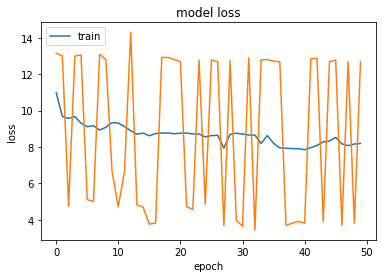

In [98]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


In [80]:
history = model.fit([X1train, X2train], ytrain, epochs=50, verbose=1, batch_size=32, callbacks=[checkpoint], validation_split=0.1, shuffle=True, workers=10, use_multiprocessing=True)
model.save(ROOT_DIR+'fit_adam_50d_2_split_finale.h5')

Train on 63707 samples, validate on 7079 samples
Epoch 1/50
14656/63707 [=====>........................] - ETA: 2:04 - loss: 5.6953

KeyboardInterrupt: 

In [99]:
import os.path as osp
import os
from pprint import pprint
from skimage.transform import rescale, resize
from skimage import data, color, io
import skimage
import PIL
import scipy
import json
import os.path
from os import path
import tensorflow as tf

from keras.applications.xception import preprocess_input
from keras.applications.xception import Xception
from keras.models import Model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import decode_predictions
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def load_image(image_path,target_size):
    img = skimage.io.imread(image_path)
    image_resized = skimage.transform.resize(img, target_size, anti_aliasing=True)
    return image_resized

def load_cnn_model():
    model = Xception()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    return model

def extract_features_from_images(image_path):
    model = load_cnn_model()
    if path.exists(image_path):
        print(image_path)
        image = load_image(image_path, target_size=(299, 299))
        if image.shape == (299, 299, 3):
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            print(feature)
            return feature

def generate_desc(model, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[word] for word in in_text.split() if word in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [103]:
from keras.models import load_model
model = load_model('fit_adam_50d_1_split_finale.h5')

In [104]:
image_path= TEST_IMAGE_DIR+'124919.jpg'#'/Users/vinutahegde/Documents/Personal/IMG_3501.JPG'
feature=extract_features_from_images(image_path)
print(generate_desc(model, feature, max_length))

/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/124919.jpg
[[0.         0.         0.14329363 ... 0.13233422 0.         0.        ]]
startseq . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [105]:
image_path=TEST_IMAGE_DIR +'124871.jpg'
feature=extract_features_from_images(image_path)
print(generate_desc(model, feature, max_length))


/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/124871.jpg
[[0.         0.         0.16217265 ... 0.11656351 0.         0.        ]]
startseq . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
